In [1]:
# Imports at the top
import json
import urllib
import pandas as pd
import numpy as np
import requests
import json
import re
import matplotlib.pyplot as plt
%matplotlib inline

# Predicting IMDB Movie Ratings 

Examine what factors lead to certain ratings for movies. Given that Netflix does not currently store this type of data, your boss has suggested that you collect ratings and reviews data from IMDB. Netflix is no stranger to machine learning, however:

- Netflix uses random forests and decision trees to predict what types of movies an individual user may like.
- Using unsupervised learning techniques, they are able to continually update suggestions, listings, and other features of its user interface.
- Netflix, however, hasn't focused on collecting data on the top movies of all time, and would like to add some of them to their offerings based on popularity and other factors.

**Point:** Your boss isn't sure where to start on this project, so your task is to collect the data, build a random forest, and examine its feature importances to understand what factors contribute to ratings.

Acquire data from IMDB, and use whatever metrics you can collect to predict whether a movie is highly rated.

When you've finished your analysis, Netflix would like a report detailing your findings, with recommendations as to next steps.

Here are some questions to keep in mind:

- What factors are the most direct predictors of rating?
- You can use rating as your target variable. But it's up to you whether to treat it as continuous, binary, or multiclass.

**Goal**: Completed Jupyter notebook that includes modeling using a random forest and an blog post explaining your findings.

# Scraping and Importing IMDB Data

In [2]:
# function to get Top 250 movies on IMDB 
# Scraping 
def get_top_250():
    response = requests.get('http://www.imdb.com/chart/top')
    html = response.text
    entries = re.findall("<a href.*?/title/(.*?)/", html)
    return list(set(entries))

In [3]:
# set entries equal to top 250 from scraped files
entries = get_top_250()

In [4]:
# get details and entries for IMDB movies, API

def get_entry(entry):
    res = requests.get('http://www.omdbapi.com/?i='+entry)
    if res.status_code != 200:
        print entry, res.status_code
    else:
        print '.',
    try:
        j = json.loads(res.text)
    except ValueError:
        j = None
    return j

In [5]:
entries_dict_list = [get_entry(e) for e in entries]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [6]:
# convert movie entires to dataframe
df = pd.DataFrame(entries_dict_list)

In [7]:
df1 = pd.read_csv('imdb_grossrev.csv', index_col=0)

# Data Cleaning & Munging

In [8]:
df.head(4)

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,Released,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,USA,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,https://images-na.ssl-images-amazon.com/images...,R,15 Oct 2014,True,107 min,Whiplash,movie,Damien Chazelle,2014,tt2582802,8.5,"413,720"
1,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Nominated for 2 Oscars. Another 5 wins & 6 nom...,Japan,Akira Kurosawa,"Action, Adventure, Drama",Japanese,98,A poor village under attack by bandits recruit...,https://images-na.ssl-images-amazon.com/images...,UNRATED,19 Nov 1956,True,207 min,Seven Samurai,movie,"Akira Kurosawa (screenplay), Shinobu Hashimoto...",1954,tt0047478,8.7,"232,249"
2,"Harrison Ford, Karen Allen, Paul Freeman, Rona...",Won 4 Oscars. Another 30 wins & 23 nominations.,USA,Steven Spielberg,"Action, Adventure","English, German, Hebrew, Spanish, Arabic, Nepali",85,Archaeologist and adventurer Indiana Jones is ...,https://images-na.ssl-images-amazon.com/images...,PG,12 Jun 1981,True,115 min,Raiders of the Lost Ark,movie,"Lawrence Kasdan (screenplay), George Lucas (st...",1981,tt0082971,8.5,"671,034"
3,"William Holden, Alec Guinness, Jack Hawkins, S...",Won 7 Oscars. Another 23 wins & 7 nominations.,"UK, USA",David Lean,"Adventure, Drama, War","English, Japanese, Thai",N/A,After settling his differences with a Japanese...,https://images-na.ssl-images-amazon.com/images...,PG,14 Dec 1957,True,161 min,The Bridge on the River Kwai,movie,"Pierre Boulle (novel), Carl Foreman (screenpla...",1957,tt0050212,8.2,"151,604"


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 20 columns):
Actors        250 non-null object
Awards        250 non-null object
Country       250 non-null object
Director      250 non-null object
Genre         250 non-null object
Language      250 non-null object
Metascore     250 non-null object
Plot          250 non-null object
Poster        250 non-null object
Rated         250 non-null object
Released      250 non-null object
Response      250 non-null object
Runtime       250 non-null object
Title         250 non-null object
Type          250 non-null object
Writer        250 non-null object
Year          250 non-null object
imdbID        250 non-null object
imdbRating    250 non-null object
imdbVotes     250 non-null object
dtypes: object(20)
memory usage: 39.1+ KB


In [10]:
# Replace N/A with NaN
df = df.replace('N/A', np.nan)

In [11]:
# convert released column to datetime type
df['Released'] = pd.to_datetime(df['Released'])

In [12]:
# strip 'min' from runtime column and convert to integer
def intminutes(x):
    y = x.replace('min','').strip()
    return int(y)

df['Runtime'] = df['Runtime'].apply(intminutes)

In [13]:
# convert year column to integer types
df['Year'] = df['Year'].astype(int)

In [14]:
# convert year column to integer types
df['Metascore'] = df['Metascore'].astype(float)

In [15]:
# strip commas from imdbVotes and convert to integer
def intvotes(x):
    y = x.replace(',', '').strip()
    return int(y)
df.imdbVotes = df.imdbVotes.apply(intvotes)

In [16]:
# combine IMDB dataframe with IMDB Gross Revenue dataframe
df = pd.merge(df, df1)

## Replace NaN with Values

In [17]:
# return all rows with NaN
df_nan = df[pd.isnull(df).any(axis = 1)]
df_nan.head(5)

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,...,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes,Gross
3,"William Holden, Alec Guinness, Jack Hawkins, S...",Won 7 Oscars. Another 23 wins & 7 nominations.,"UK, USA",David Lean,"Adventure, Drama, War","English, Japanese, Thai",NaN,After settling his differences with a Japanese...,https://images-na.ssl-images-amazon.com/images...,PG,...,True,161,The Bridge on the River Kwai,movie,"Pierre Boulle (novel), Carl Foreman (screenpla...",1957,tt0050212,8.2,151604,27200000.0
7,"Yves Montand, Charles Vanel, Folco Lulli, Pete...",Won 1 BAFTA Film Award. Another 5 wins.,"France, Italy",Henri-Georges Clouzot,"Adventure, Drama, Thriller","French, English, Spanish, German, Italian, Rus...",NaN,"In a decrepit South American village, men are ...",https://images-na.ssl-images-amazon.com/images...,NOT RATED,...,True,131,The Wages of Fear,movie,"Georges Arnaud (novel), Henri-Georges Clouzot ...",1953,tt0046268,8.2,35833,NaN
8,"Toshirô Mifune, Tatsuya Nakadai, Yôko Tsukasa,...",Nominated for 1 Oscar. Another 4 wins & 1 nomi...,Japan,Akira Kurosawa,"Action, Drama, Thriller",Japanese,NaN,A crafty ronin comes to a town divided by two ...,https://images-na.ssl-images-amazon.com/images...,UNRATED,...,True,110,Yojimbo,movie,"Akira Kurosawa (story), Akira Kurosawa (screen...",1961,tt0055630,8.3,75317,NaN
10,"Bette Davis, Anne Baxter, George Sanders, Cele...",Won 6 Oscars. Another 16 wins & 17 nominations.,USA,Joseph L. Mankiewicz,Drama,"English, French",NaN,An ingenue insinuates herself into the company...,https://images-na.ssl-images-amazon.com/images...,APPROVED,...,True,138,All About Eve,movie,Joseph L. Mankiewicz (written for the screen by),1950,tt0042192,8.3,84353,10177.0
14,"Steve McQueen, James Garner, Richard Attenboro...",Nominated for 1 Oscar. Another 2 wins & 7 nomi...,USA,John Sturges,"Adventure, Drama, History","English, German, French, Russian, Spanish",NaN,Allied P.O.W.s plan for several hundred of the...,https://images-na.ssl-images-amazon.com/images...,APPROVED,...,True,172,The Great Escape,movie,"Paul Brickhill (book), James Clavell (screenpl...",1963,tt0057115,8.3,167926,NaN


In [18]:
# Print number of NaN in all columns

nan_list = []

for col in df.columns:
    x = sum(pd.isnull(df[col]))
    if x != 0:
        nan_list.append(col)
        print col, x

Awards 4
Language 1
Metascore 81
Poster 2
Rated 1
Released 1
Gross 66


In [19]:
# Find row where Language is NaN
df[pd.isnull(df['Language'])]

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,...,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes,Gross
194,"George O'Brien, Janet Gaynor, Margaret Livings...",Won 3 Oscars. Another 2 wins & 1 nomination.,USA,F.W. Murnau,"Drama, Romance",NaN,NaN,A married farmer falls under the spell of a sl...,NaN,NOT RATED,...,True,94,Sunrise,movie,"Carl Mayer (scenario), Hermann Sudermann (from...",1927,tt0018455,8.3,29635,NaN


In [20]:
# Change language of movie "Sunrise" to "English"
df.loc[df['Title'] == 'Sunrise' , 'Language'] = 'English'

In [21]:
# Find movie with NaN in Rating

df[pd.isnull(df['Rated'])]

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,...,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes,Gross
137,"Manoj Bajpayee, Richa Chadha, Nawazuddin Siddi...",10 wins & 32 nominations.,India,Anurag Kashyap,"Action, Crime, Drama",Hindi,89.0,A clash between Sultan and Shahid Khan leads t...,https://images-na.ssl-images-amazon.com/images...,NaN,...,True,320,Gangs of Wasseypur,movie,"Akhilesh Jaiswal, Anurag Kashyap, Sachin K. La...",2012,tt1954470,8.3,48140,NaN


In [22]:
# List of all unique ratings
df['Rated'].unique()

array([u'R', u'UNRATED', u'PG', u'PG-13', u'NOT RATED', u'G', u'APPROVED',
       u'PASSED', nan, u'M'], dtype=object)

In [23]:
# Change rating of 'Gangs of Wasseypur' from NaN to 'UNRATED'

df.loc[df['Title'] == 'Gangs of Wasseypur' , 'Rated'] = 'UNRATED'

In [24]:
# Find movie with NaN in "Released"

df[pd.isnull(df['Released'])]

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,...,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes,Gross
73,"Charles Chaplin, Mack Swain, Tom Murray, Henry...",Nominated for 2 Oscars. Another 3 wins & 1 nom...,USA,Charles Chaplin,"Adventure, Comedy, Drama",English,NaN,A prospector goes to the Klondike in search of...,https://images-na.ssl-images-amazon.com/images...,NOT RATED,...,True,95,The Gold Rush,movie,Charles Chaplin,1925,tt0015864,8.2,69196,NaN


In [25]:
# Change released date of  of 'The Gold Rush' from NaN to '1925-06-26'

df.loc[df['Title'] == 'The Gold Rush' , 'Released'] = pd.to_datetime('1925-06-26')

In [26]:
# Fill in 0 for NaN Gross Revenue values

df['Gross'].fillna(0, inplace=True)

In [27]:
# Drop "Awards" column - colinearity of awards and rating
df.drop('Awards',axis=1, inplace=True)

In [28]:
# Drop "Poster" column - image type
df.drop('Poster',axis=1, inplace=True)

In [29]:
# Drop "Metascore" column - Colinearity/NaN
df.drop('Metascore',axis=1, inplace=True)

In [30]:
# Drop "imdbID" column - just IDs
df.drop('imdbID',axis=1, inplace=True)

In [31]:
# Drop "Writer" column - Too many different writers
df.drop('Writer',axis=1, inplace=True)

In [32]:
# Drop "Type" column - All type = movies
df.drop('Type',axis=1, inplace=True)

In [33]:
# Drop "Response" column - All Response = True
df.drop('Response',axis=1, inplace=True)

In [34]:
df.head()

,Actors,Country,Director,Genre,Language,Plot,Rated,Released,Runtime,Title,Year,imdbRating,imdbVotes,Gross
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",USA,Damien Chazelle,"Drama, Music",English,A promising young drummer enrolls at a cut-thr...,R,2014-10-15,107,Whiplash,2014,8.5,413720,13092000.0
1,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Japan,Akira Kurosawa,"Action, Adventure, Drama",Japanese,A poor village under attack by bandits recruit...,UNRATED,1956-11-19,207,Seven Samurai,1954,8.7,232249,269061.0
2,"Harrison Ford, Karen Allen, Paul Freeman, Rona...",USA,Steven Spielberg,"Action, Adventure","English, German, Hebrew, Spanish, Arabic, Nepali",Archaeologist and adventurer Indiana Jones is ...,PG,1981-06-12,115,Raiders of the Lost Ark,1981,8.5,671034,242374454.0
3,"William Holden, Alec Guinness, Jack Hawkins, S...","UK, USA",David Lean,"Adventure, Drama, War","English, Japanese, Thai",After settling his differences with a Japanese...,PG,1957-12-14,161,The Bridge on the River Kwai,1957,8.2,151604,27200000.0
4,"Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",USA,Joss Whedon,"Action, Sci-Fi, Thriller","English, Russian",Earth's mightiest heroes must come together an...,PG-13,2012-05-04,143,The Avengers,2012,8.1,1010033,623279547.0


## TEXT VECTORIZATION

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
# CountVectorize Genre Column (dummy variables)

cv = CountVectorizer(tokenizer=lambda x: x.split(', '),binary=True, max_features=50)
data = cv.fit_transform(df.Genre).todense()
columns = ['genre_'+c for c in cv.get_feature_names()]
genredf = pd.DataFrame(data, columns=columns)
genredf.head()

,genre_action,genre_adventure,genre_animation,genre_biography,genre_comedy,genre_crime,genre_drama,genre_family,genre_fantasy,genre_film-noir,...,genre_horror,genre_music,genre_musical,genre_mystery,genre_romance,genre_sci-fi,genre_sport,genre_thriller,genre_war,genre_western
0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [37]:
# Sum of movies by Genre (choose which column to drop)
genredf.sum().head(10)

genre_action        38
genre_adventure     62
genre_animation     20
genre_biography     26
genre_comedy        41
genre_crime         55
genre_drama        172
genre_family        14
genre_fantasy       22
genre_film-noir      7
dtype: int64

In [38]:
# drop genre_music for classification purposes

genredf.drop('genre_music',axis=1, inplace=True)

In [39]:
df = pd.concat([df, genredf], axis = 1)

In [40]:
# CountVectorize Actor Columns (dummy variables)

cv = CountVectorizer(tokenizer=lambda x: x.split(', '), binary=True, max_features=50)
data = cv.fit_transform(df.Actors).todense()
columns = ['actor: '+c for c in cv.get_feature_names()]
actorsdf = pd.DataFrame(data, columns=columns)
actorsdf.head()

,actor: aamir khan,actor: al pacino,actor: alec guinness,actor: ben kingsley,actor: brad pitt,actor: bruce willis,actor: carrie fisher,actor: carrie-anne moss,actor: charles chaplin,actor: charles vanel,...,actor: robert duvall,actor: russell crowe,actor: sean astin,actor: sigourney weaver,actor: steve buscemi,actor: takashi shimura,actor: tom hanks,actor: tom hardy,actor: toshirô mifune,actor: william holden
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# Sum of movies by Actor (choose which column to drop)
# Don't need to drop due to already dropped (max 50)

actorsdf.sum().head(10)

actor: aamir khan          2
actor: al pacino           4
actor: alec guinness       3
actor: ben kingsley        3
actor: brad pitt           4
actor: bruce willis        3
actor: carrie fisher       4
actor: carrie-anne moss    2
actor: charles chaplin     4
actor: charles vanel       2
dtype: int64

In [42]:
# combine actor and main dataframe

df = pd.concat([df, actorsdf], axis = 1)

In [43]:
# CountVectorize Language Column (dummy variables)

cv = CountVectorizer(tokenizer=lambda x: x.split(', '),binary=True, max_features=50)
data = cv.fit_transform(df.Language).todense()
columns = ['Language: '+c for c in cv.get_feature_names()]
lang_df = pd.DataFrame(data, columns=columns)
lang_df.head()

,Language: american sign language,Language: arabic,Language: awadhi,Language: belarusian,Language: cantonese,Language: czech,Language: danish,Language: english,Language: esperanto,Language: french,...,Language: spanish,Language: swahili,Language: swedish,Language: thai,Language: turkish,Language: urdu,Language: vietnamese,Language: xhosa,Language: yiddish,Language: zulu
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# Sum of movies by Language (choose which column to drop)

lang_df.sum().head(10)

Language: american sign language      1
Language: arabic                      8
Language: awadhi                      1
Language: belarusian                  1
Language: cantonese                   5
Language: czech                       1
Language: danish                      2
Language: english                   211
Language: esperanto                   1
Language: french                     42
dtype: int64

In [45]:
# drop 'Language: american sign language' for classification purposes

lang_df.drop('Language: american sign language',axis=1, inplace=True)

In [46]:
# combine language and main dataframe

df = pd.concat([df, lang_df], axis = 1)

In [47]:
# CountVectorize Country Column (dummy variables)

cv = CountVectorizer(tokenizer=lambda x: x.split(', '),binary=True, max_features=50)
data = cv.fit_transform(df.Country).todense()
columns = ['Country: '+c for c in cv.get_feature_names()]
coun_df = pd.DataFrame(data, columns=columns)
coun_df.head()

,Country: algeria,Country: argentina,Country: australia,Country: austria,Country: belgium,Country: brazil,Country: canada,Country: china,Country: denmark,Country: france,...,Country: south korea,Country: soviet union,Country: spain,Country: sweden,Country: switzerland,Country: taiwan,Country: uk,Country: united arab emirates,Country: usa,Country: west germany
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [48]:
# Sum of movies by country (choose which column to drop)

coun_df.sum().head(10)

Country: algeria       1
Country: argentina     2
Country: australia     3
Country: austria       2
Country: belgium       1
Country: brazil        1
Country: canada        4
Country: china         1
Country: denmark       2
Country: france       20
dtype: int64

In [49]:
# drop 'Country: luxemborg' for classification purposes

coun_df.drop('Country: luxembourg',axis=1, inplace=True)

In [50]:
# combine country and main dataframe

df = pd.concat([df, coun_df], axis = 1)

In [51]:
# CountVectorize Director Column (dummy variables)

cv = CountVectorizer(tokenizer=lambda x: x.split(', '),binary=True, max_features=50)
data = cv.fit_transform(df.Director).todense()
columns = ['Director: '+c for c in cv.get_feature_names()]
direc_df = pd.DataFrame(data, columns=columns)
direc_df.head()

,Director: akira kurosawa,Director: alejandro g. iñárritu,Director: alfred hitchcock,Director: andrew stanton,Director: billy wilder,Director: charles chaplin,Director: christopher nolan,Director: clint eastwood,Director: david fincher,Director: david lean,...,Director: roman polanski,Director: ron howard,Director: sergio leone,Director: sidney lumet,Director: stanley kubrick,Director: steven spielberg,Director: terry gilliam,Director: terry jones,Director: victor fleming,Director: william wyler
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# Sum of movies by director (choose which column to drop)
# Don't need to drop due to already dropped (max 50)

direc_df.sum().head(10)

Director: akira kurosawa           5
Director: alejandro g. iñárritu    2
Director: alfred hitchcock         7
Director: andrew stanton           2
Director: billy wilder             5
Director: charles chaplin          5
Director: christopher nolan        7
Director: clint eastwood           3
Director: david fincher            3
Director: david lean               2
dtype: int64

In [53]:
# combine director and main dataframe

df = pd.concat([df, direc_df], axis = 1)

In [54]:
# drop columns Actors, Genre, Language, Plot, Country, Director

df.drop(['Actors','Genre','Language','Plot','Country','Director'],axis=1, inplace=True)

In [55]:
# Convert imdbRating to float

df['imdbRating'] = df['imdbRating'].astype(float)

In [56]:
# Drop duplicates

df.drop_duplicates(inplace=True)

In [57]:
df.head()

,Rated,Released,Runtime,Title,Year,imdbRating,imdbVotes,Gross,genre_action,genre_adventure,...,Director: roman polanski,Director: ron howard,Director: sergio leone,Director: sidney lumet,Director: stanley kubrick,Director: steven spielberg,Director: terry gilliam,Director: terry jones,Director: victor fleming,Director: william wyler
0,R,2014-10-15,107,Whiplash,2014,8.5,413720,13092000.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,UNRATED,1956-11-19,207,Seven Samurai,1954,8.7,232249,269061.0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,PG,1981-06-12,115,Raiders of the Lost Ark,1981,8.5,671034,242374454.0,1,1,...,0,0,0,0,0,1,0,0,0,0
3,PG,1957-12-14,161,The Bridge on the River Kwai,1957,8.2,151604,27200000.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,PG-13,2012-05-04,143,The Avengers,2012,8.1,1010033,623279547.0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Exploratory Data Analysis (EDA)

In [58]:
import seaborn as sns

In [59]:
# Describe the data
df.describe()

,Runtime,Year,imdbRating,imdbVotes,Gross,genre_action,genre_adventure,genre_animation,genre_biography,genre_comedy,...,Director: roman polanski,Director: ron howard,Director: sergio leone,Director: sidney lumet,Director: stanley kubrick,Director: steven spielberg,Director: terry gilliam,Director: terry jones,Director: victor fleming,Director: william wyler
count,250.000000,250.00000,250.000000,2.500000e+02,2.500000e+02,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,129.196000,1984.03600,8.311600,4.123158e+05,8.063931e+07,0.152000,0.248000,0.080000,0.104000,0.164000,...,0.008000,0.008000,0.020000,0.012000,0.028000,0.028000,0.008000,0.008000,0.008000,0.012000
std,32.563524,24.25953,0.231603,3.389860e+05,1.287048e+08,0.359741,0.432718,0.271837,0.305873,0.371018,...,0.089263,0.089263,0.140281,0.109104,0.165304,0.165304,0.089263,0.089263,0.089263,0.109104
min,67.000000,1921.00000,8.000000,2.627400e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,107.000000,1964.25000,8.100000,1.218620e+05,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,124.000000,1991.00000,8.300000,3.302050e+05,2.118502e+07,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,143.000000,2003.75000,8.400000,6.027400e+05,1.171431e+08,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,320.000000,2016.00000,9.300000,1.711064e+06,9.366274e+08,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
# Correlation of features
df3 = df[['Runtime','Year','imdbRating','imdbVotes']]
df3.corr()

,Runtime,Year,imdbRating,imdbVotes
Runtime,1.000000,0.143044,0.218930,0.164775
Year,0.143044,1.000000,-0.046964,0.492797
imdbRating,0.218930,-0.046964,1.000000,0.554620
imdbVotes,0.164775,0.492797,0.554620,1.000000


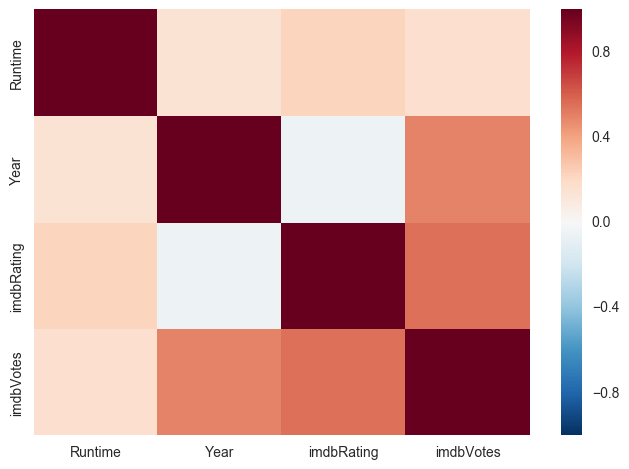

In [61]:
# Heatmap of correlation between features
sns.heatmap(df3.corr());

In [62]:
# Top Grossing Movies

tgm = df[['Title','Gross']].sort_values('Gross', ascending = False).head(10)
tgm

,Title,Gross
160,Star Wars: The Force Awakens,936627416.0
4,The Avengers,623279547.0
37,The Dark Knight,533316061.0
235,Star Wars: Episode IV - A New Hope,460935665.0
159,The Dark Knight Rises,448130642.0
48,The Lion King,422783777.0
100,Toy Story 3,414984497.0
68,Harry Potter and the Deathly Hallows: Part 2,380955619.0
9,Finding Nemo,380838870.0
78,The Lord of the Rings: The Return of the King,377019252.0


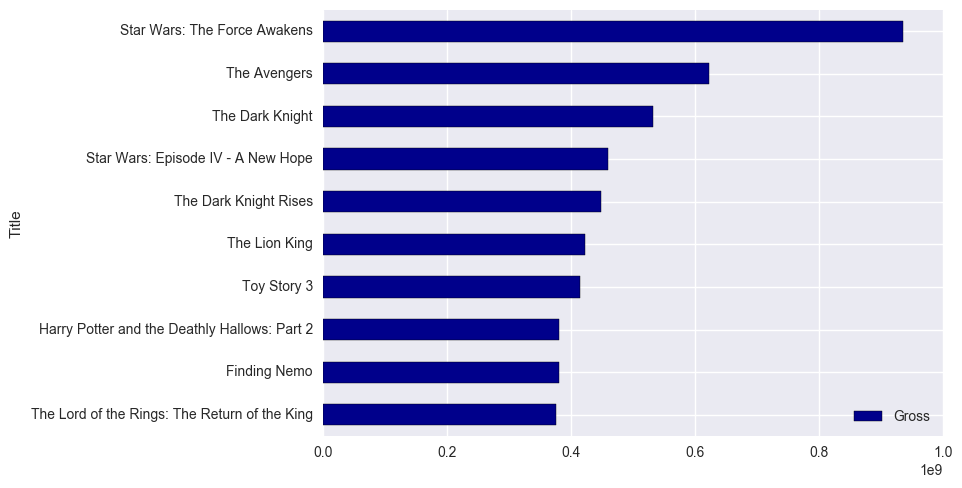

In [63]:
# The highest grossing movie "Star Wars: The Force Awakens" is the highest grossing film
tgm.plot(kind='barh', x='Title',y='Gross', color='darkblue')
plt.gca().invert_yaxis()

In [64]:
# Top 10 Rated Movies

trm = df[['Title','imdbRating']].sort_values('imdbRating', ascending = False)
trm.head(10)

,Title,imdbRating
213,The Shawshank Redemption,9.3
143,The Godfather,9.2
215,The Godfather: Part II,9.0
37,The Dark Knight,9.0
193,Pulp Fiction,8.9
58,Schindler's List,8.9
191,12 Angry Men,8.9
78,The Lord of the Rings: The Return of the King,8.9
208,"The Good, the Bad and the Ugly",8.9
232,Inception,8.8


(8, 10)

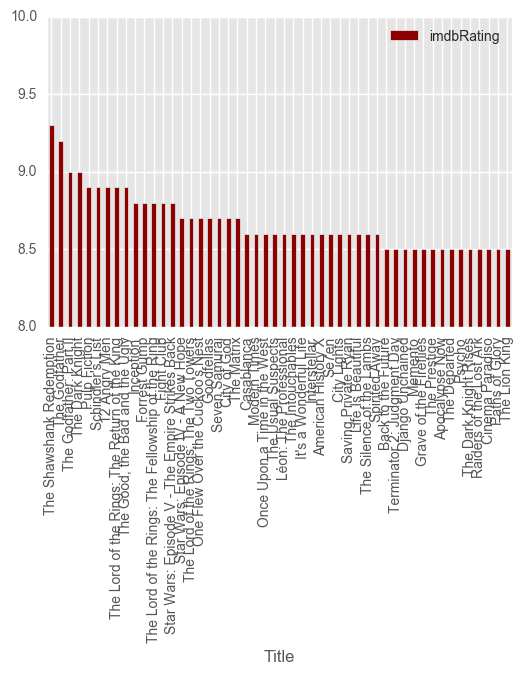

In [104]:
# No movie is rated above 9.5 and all 250 movies are 8 or above in rating.
trm.head(50).plot(kind='bar',x='Title',y='imdbRating', color ='darkred')
plt.gca().set_ylim([8,10])

In [66]:
# Top 10 Movies with Longest Runtime

df[['Title','Runtime']].sort_values('Runtime', ascending = False).head(10)

,Title,Runtime
137,Gangs of Wasseypur,320
239,Gone with the Wind,238
38,Once Upon a Time in America,229
179,Lagaan: Once Upon a Time in India,224
112,Lawrence of Arabia,216
43,Ben-Hur,212
1,Seven Samurai,207
215,The Godfather: Part II,202
78,The Lord of the Rings: The Return of the King,201
58,Schindler's List,195


In [67]:
# Top 10 Movies with the Largest # of Votes

df[['Title','imdbVotes']].sort_values('imdbVotes', ascending = False).head(10)

,Title,imdbVotes
213,The Shawshank Redemption,1711064
37,The Dark Knight,1699835
232,Inception,1489067
181,Fight Club,1373233
193,Pulp Fiction,1343852
224,Forrest Gump,1279349
134,The Lord of the Rings: The Fellowship of the Ring,1252518
128,The Matrix,1233966
78,The Lord of the Rings: The Return of the King,1230433
143,The Godfather,1169904


In [68]:
# Actors that appear the most in the Top Rated 250 movies on IMDB

actorsdf.sum().sort_values(ascending=False).head(10)

actor: leonardo dicaprio    7
actor: harrison ford        7
actor: robert de niro       7
actor: tom hanks            6
actor: clint eastwood       6
actor: tom hardy            5
actor: mark hamill          5
actor: carrie fisher        4
actor: brad pitt            4
actor: james stewart        4
dtype: int64

In [69]:
# Directors who directed the most number of the highest rated movies

director = direc_df.sum().sort_values(ascending=False)
director.head(10)

Director: alfred hitchcock     7
Director: steven spielberg     7
Director: stanley kubrick      7
Director: christopher nolan    7
Director: martin scorsese      7
Director: hayao miyazaki       6
Director: quentin tarantino    6
Director: akira kurosawa       5
Director: billy wilder         5
Director: charles chaplin      5
dtype: int64

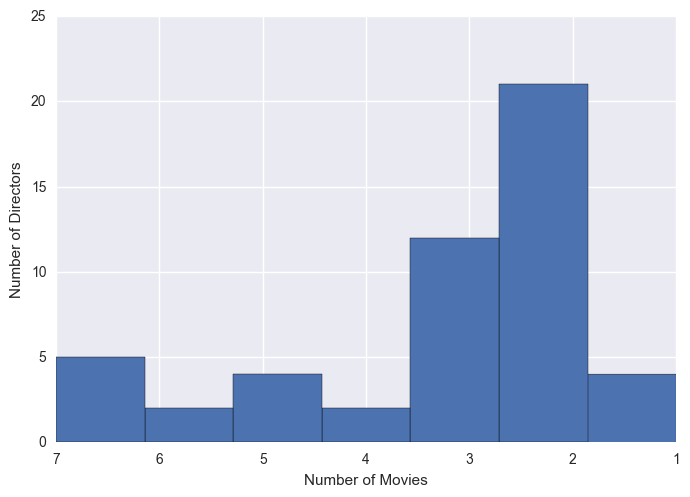

In [70]:
# The number of movies directed vs number of directors

director.hist(bins=7);
plt.gca().invert_xaxis()
plt.ylabel('Number of Directors')
plt.xlabel('Number of Movies')


In [71]:
# Most popular language in top 250 highest rated movies

lang_df.sum().sort_values(ascending=False).head(10)

Language: english      211
Language: french        42
Language: german        34
Language: spanish       30
Language: italian       23
Language: japanese      19
Language: russian       15
Language: latin         10
Language: arabic         8
Language: cantonese      5
dtype: int64

In [72]:
# Most popular genres for the top 250 highest rated movies

genre = genredf.sum().sort_values(ascending=False)
genre.head(10)

genre_drama        172
genre_adventure     62
genre_crime         55
genre_comedy        41
genre_thriller      40
genre_action        38
genre_mystery       30
genre_biography     26
genre_sci-fi        23
genre_fantasy       22
dtype: int64

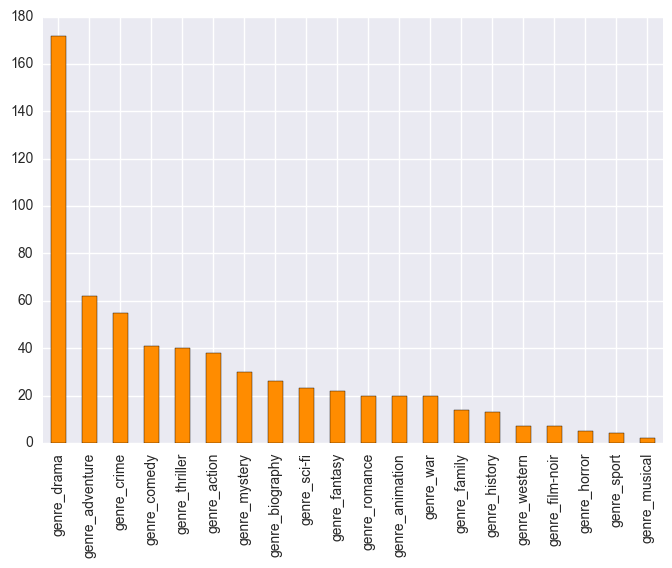

In [73]:
genre.plot(kind='bar', color='darkorange');

# Decision Trees

In [74]:
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import Imputer
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [75]:
# find mean of imdb rating

mean=df['imdbRating'].mean()
mean

8.311599999999995

In [76]:
# convert imdb rating column to binary (1 for above mean, 0 for below mean)

df1['imdbRating']=[1 if x>mean else 0 for x in df['imdbRating']]

In [77]:
# X dropped release data (colinearity with year), imdbRating(our target), Rated and Title(assumption of non-importance)

X = df.drop(['Title','Released','imdbRating','Rated'], axis=1)
y = df1['imdbRating']

In [78]:
# Train and Test X & Y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [79]:
# function for evaluating models
# confusion matrix, accuracy score, classificaiton report

def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    a = accuracy_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    
    print cm
    print cr
    
    return a

all_models = {}

In [80]:
# evaluate decision tree classifer model - precision, recall, f1 score

dt = DecisionTreeClassifier()
all_models['dt'] = {'model': dt,
                    'score': evaluate_model(dt)}

[[39  8]
 [10 18]]
             precision    recall  f1-score   support

          0       0.80      0.83      0.81        47
          1       0.69      0.64      0.67        28

avg / total       0.76      0.76      0.76        75



In [81]:
# find the most important features in decision trees

feature_importances = pd.DataFrame(dt.feature_importances_,
                                   index = X.columns,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(20)

,importance
imdbVotes,0.402476
Year,0.107935
Gross,0.094919
actor: sigourney weaver,0.041594
genre_drama,0.028463
Director: francis ford coppola,0.023948
Language: hebrew,0.023187
Country: iran,0.022909
actor: janet leigh,0.022463
Country: morocco,0.021818


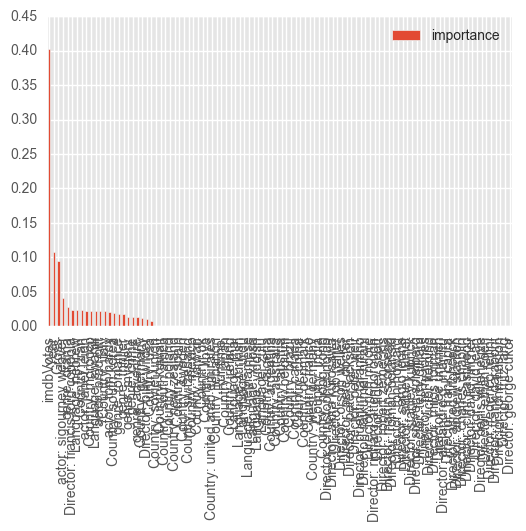

In [82]:
# imdbVotes are 4x more important in predicting imdbRating than the next (Year)

featimp = feature_importances.sort_values(by='importance', ascending=False).head(100)
featimp.plot(kind='bar');

In [83]:
# Gridsearch on Decision Trees

params = {'criterion': ['gini', 'entropy'],
          'splitter': ['best', 'random'],
          'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3]}

gsdt = GridSearchCV(dt,
                    params, n_jobs=-1,
                    cv=KFold(len(y), n_folds=3, shuffle=True))

gsdt.fit(X, y)
print gsdt.best_params_
print gsdt.best_score_

all_models['gsdt'] = {'model': gsdt.best_estimator_,
                      'score': evaluate_model(gsdt.best_estimator_)}

{'min_samples_split': 5, 'splitter': 'best', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2}
0.792
[[38  9]
 [10 18]]
             precision    recall  f1-score   support

          0       0.79      0.81      0.80        47
          1       0.67      0.64      0.65        28

avg / total       0.74      0.75      0.75        75



In [84]:
# Bagging Gridsearch Decision Trees

bagging_params = {'n_estimators': [10, 20],
                  'max_samples': [0.7, 1.0],
                  'max_features': [0.7, 1.0],
                  'bootstrap_features': [True, False]}

gsbaggingdt = GridSearchCV(BaggingClassifier(gsdt.best_estimator_),
                           bagging_params, n_jobs=-1,
                           cv=KFold(len(y), n_folds=3, shuffle=True))

gsbaggingdt.fit(X, y)

print gsbaggingdt.best_params_

print gsbaggingdt.best_score_

all_models['gsbaggingdt'] = {'model': gsbaggingdt.best_estimator_,
                             'score': evaluate_model(gsbaggingdt.best_estimator_)}

//anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
//anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
//anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
//anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


{'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'bootstrap_features': False}
0.78
[[46  1]
 [10 18]]
             precision    recall  f1-score   support

          0       0.82      0.98      0.89        47
          1       0.95      0.64      0.77        28

avg / total       0.87      0.85      0.85        75



In [85]:
# Random Forest Classifier

rf = RandomForestClassifier()
all_models['rf'] = {'model': rf,
                    'score': evaluate_model(rf)}


# Random Trees Classifier

et = ExtraTreesClassifier()
all_models['et'] = {'model': et,
                    'score': evaluate_model(et)}

[[46  1]
 [19  9]]
             precision    recall  f1-score   support

          0       0.71      0.98      0.82        47
          1       0.90      0.32      0.47        28

avg / total       0.78      0.73      0.69        75

[[42  5]
 [21  7]]
             precision    recall  f1-score   support

          0       0.67      0.89      0.76        47
          1       0.58      0.25      0.35        28

avg / total       0.64      0.65      0.61        75



In [86]:
# Compare feature importances for decision trees, random forest, and extra trees

importances = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('rf_importance',
                                                                   ascending=False)


importances_plot = importances.head(20)
importances_plot

,dt_importance,rf_importance,et_importance
imdbVotes,0.402476,0.226633,0.124624
Runtime,0.000000,0.079552,0.036708
Year,0.107935,0.077697,0.058222
Gross,0.094919,0.056288,0.038167
genre_crime,0.013009,0.020674,0.022005
actor: sigourney weaver,0.041594,0.019144,0.006543
genre_romance,0.017346,0.018570,0.004754
Country: france,0.000000,0.018512,0.013845
genre_action,0.000000,0.018345,0.004564
Language: english,0.000000,0.016296,0.015185


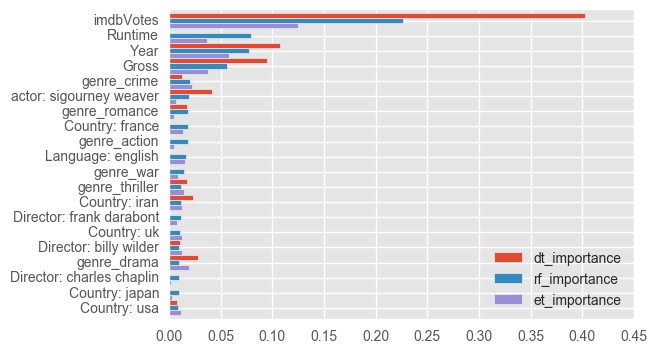

In [102]:
importances_plot.plot(kind='barh', width=1.0);
plt.gca().invert_yaxis()

In [88]:
# Gridsearch Random Forests

params = {'n_estimators':[3, 5, 10, 50],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


gsrf = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=KFold(len(y), n_folds=3, shuffle=True))

gsrf.fit(X, y)
print gsrf.best_params_
print gsrf.best_score_

all_models['gsrf'] = {'model': gsrf.best_estimator_,
                      'score': evaluate_model(gsrf.best_estimator_)}

{'min_samples_split': 2, 'n_estimators': 50, 'criterion': 'entropy', 'max_depth': None, 'class_weight': 'balanced'}
0.736
[[43  4]
 [21  7]]
             precision    recall  f1-score   support

          0       0.67      0.91      0.77        47
          1       0.64      0.25      0.36        28

avg / total       0.66      0.67      0.62        75



,score
model,
gsbaggingdt,0.853333
dt,0.760000
gsdt,0.746667
rf,0.733333
gsrf,0.666667
et,0.653333


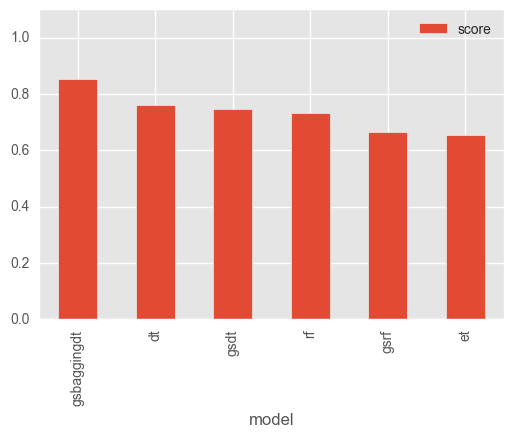

In [94]:
# Scores of all the models

scores = pd.DataFrame([(k, v['score']) for k, v in all_models.iteritems()],
             columns=['model', 'score']).set_index('model').sort_values('score', ascending=False)


scores.plot(kind='bar')
plt.ylim(0, 1.1)

scores

In [90]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold

def retest(model):
    scores = cross_val_score(model, X, y,
                             cv=StratifiedKFold(y, shuffle=True),
                             n_jobs=-1)
    m = scores.mean()
    s = scores.std()
    
    return m, s

for k, v in all_models.iteritems():
    cvres = retest(v['model'])
    print k, 
    all_models[k]['cvres'] = cvres

gsrf rf

//anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
//anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
//anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


 gsbaggingdt gsdt et dt


,score,error
model,,
gsrf,0.767977,0.006419
gsbaggingdt,0.739912,0.021438
dt,0.736087,0.042261
gsdt,0.735944,0.045370
rf,0.723991,0.009959
et,0.648068,0.027410


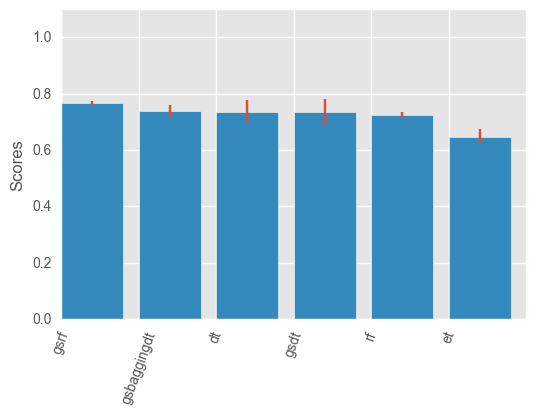

In [95]:
# Scores and errors for all decision tree methods

cvscores = pd.DataFrame([(k, v['cvres'][0], v['cvres'][1] ) for k, v in all_models.iteritems()],
                        columns=['model', 'score', 'error']).set_index('model').sort_values('score', ascending=False)



fig, ax = plt.subplots()
rects1 = ax.bar(range(len(cvscores)), cvscores.score,
                yerr=cvscores.error,
                tick_label=cvscores.index)

ax.set_ylabel('Scores')
plt.xticks(rotation=70)
plt.ylim(0, 1.1)

cvscores

# NEXT STEPS